### LA CIENCIA DE DATOS: ANÁLISIS, MINERIA Y VISUALIZACIÓN
## UNIDAD 5 CASO PRÁCTICO 2

### DATOS
Un tipo muy habitual de datos con los que se trabaja en ciencia de datos son las series temporales. Una de las características especiales de las series temporales es que una sola variable, el tiempo, puede dar lugar a muchas dimensiones, como puede ser el día de la semana, la hora del día, etc.

En este caso práctico, se analiza una serie de datos de tráfico en la cuidad de Madrid, disponibles en un fichero que se proporciona. Se trata de un conjunto de datos algo más grande que en otros casos prácticos (once millones de registros), lo que no es bastante como para generar problemas de rendimiento significativos, pero sí como para que sea necesario aplicar sistemáticamente técnicas de sumarización de los datos.

Como en otros casos anteriores, se sugiere al alumno continuar el análisis de los datos más allá de lo solicitado en este caso, ya que se trata de un conjunto de datos muy rico y que se presta fácilmente a hacer descubrimientos fácilmente interpretables.

## TRABAJO
A partir del siguiente juego de datos:

1. Importar los datos de tráfico proporcionados y cargarlos en un dataframe de Pandas, con los tipos adecuados y realizando una limpieza de datos básica.
2. Para los datos correspondientes a la M30 (vía de circunvalación de la ciudad de Madrid), comparar los valores de velocidad media e intensidad de tráfico entre distintos puntos.
3. Utilizando métricas típicas de comparación de series temporales, analizar las similitudes y diferencias en los patrones diarios de congestión del tráfico entre los distintos días de la semana.

## DATA WRANGLING
Once millones de registros hacen que el archivo sea incomodo de ver (por lo menos en una pantalla normal de computador). Comencemos por leer el archivo en un *dataframe* de *Pandas* y tratar de discernir como mejor manipular los datos.  

In [1]:
# Lectura del archivo
import pandas as pd

data = pd.read_csv('11-2019.csv')
data.head()

,"id;""fecha"";""tipo_elem"";""intensidad"";""ocupacion"";""carga"";""vmed"";""error"";""periodo_integracion"""
0,"1001;""2019-11-01 00:00:00"";""M30"";""1320"";""3"";""0..."
1,"1001;""2019-11-01 00:15:00"";""M30"";""1260"";""3"";""0..."
2,"1001;""2019-11-01 00:30:00"";""M30"";""948"";""3"";""0""..."
3,"1001;""2019-11-01 00:45:00"";""M30"";""888"";""3"";""0""..."
4,"1001;""2019-11-01 01:00:00"";""M30"";""972"";""3"";""0""..."


El formato es el típico de España donde en vez de `,` para separador se utiliza `;`. No se ven tildes presentes, por lo que no nos debemos preocupar por el __encoding__. Volvamos a leer el archivo esta vez con otro separador. 

In [2]:
# Lectura del archivo español
data = pd.read_csv('11-2019.csv', sep = ';')
data.head()

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2019-11-01 00:00:00,M30,1320,3.0,0,50.0,N,5
1,1001,2019-11-01 00:15:00,M30,1260,3.0,0,54.0,N,5
2,1001,2019-11-01 00:30:00,M30,948,3.0,0,56.0,N,5
3,1001,2019-11-01 00:45:00,M30,888,3.0,0,59.0,N,5
4,1001,2019-11-01 01:00:00,M30,972,3.0,0,59.0,N,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11186837 entries, 0 to 11186836
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   fecha                object 
 2   tipo_elem            object 
 3   intensidad           int64  
 4   ocupacion            float64
 5   carga                int64  
 6   vmed                 float64
 7   error                object 
 8   periodo_integracion  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 768.1+ MB


Lo primero que salta a la vista es que el archivo tiene una variable llamada `fecha` que _Python_ lee como una primitiva tipo `object`. Vamos a tener que forjarla como fecha.

In [4]:
# El siguiente código cortesia de Stack Overflow
# https://stackoverflow.com/questions/38333954/converting-object-to-datetime-format-in-python
# by https://stackoverflow.com/users/509824/alberto-garcia-raboso
data['fecha'] = pd.to_datetime(data['fecha'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11186837 entries, 0 to 11186836
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   fecha                datetime64[ns]
 2   tipo_elem            object        
 3   intensidad           int64         
 4   ocupacion            float64       
 5   carga                int64         
 6   vmed                 float64       
 7   error                object        
 8   periodo_integracion  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 768.1+ MB


Veamos el alcance de la primera variable `id`.

In [5]:
data['id'].describe()

count    1.118684e+07
mean     5.878039e+03
std      2.037029e+03
min      1.001000e+03
25%      4.446000e+03
50%      5.533000e+03
75%      6.587000e+03
max      1.051400e+04
Name: id, dtype: float64

Honestamente, `id` parece un tipo de identificador, pero es difícil en once millones de registros ver de que se trata. Busquemos y contemos los casos únicos a ver si ayuda.

In [6]:
data['id'].value_counts()

7145    2880
5722    2880
5715    2880
5712    2880
5713    2880
        ... 
9911       1
4689       1
5867       1
5998       1
6048       1
Name: id, Length: 4039, dtype: int64

Nuevamente, la solución común no nos dice mucho. Usemos una solución propuesta en Stack Overflow.

In [7]:
# Solución propuesta en Stack Overflow
# https://stackoverflow.com/questions/34178751/extract-unique-
# values-and-number-of-occurrences-of-each-value-from-dataframe-col
# by https://stackoverflow.com/users/925592/rufusvs
from collections import Counter
Counter(data['id'])

Counter({1001: 2880,
         1002: 2880,
         1003: 2880,
         1006: 2878,
         1009: 2880,
         1010: 2880,
         1011: 2880,
         1012: 2880,
         1013: 2880,
         1014: 2880,
         1015: 2880,
         1016: 2880,
         1017: 2880,
         1018: 2880,
         1019: 2880,
         1020: 2880,
         1021: 2880,
         1022: 2880,
         1023: 2880,
         1024: 2880,
         1025: 2880,
         1026: 2880,
         1027: 1260,
         1028: 2880,
         1029: 2880,
         1030: 2880,
         1031: 2880,
         1032: 2880,
         1033: 2880,
         1034: 2880,
         1035: 2880,
         1036: 2880,
         1037: 2880,
         1038: 2880,
         1039: 2880,
         1040: 2880,
         1041: 2880,
         1042: 2880,
         1043: 2880,
         1044: 2880,
         1045: 2880,
         1046: 2880,
         1047: 2880,
         1048: 2880,
         1049: 2880,
         1050: 2880,
         1052: 2880,
         3395

A primera vista vemos que con algunas excepciones, hay un promedio de 2,880 mediciones para cada `id`. Lo interesante es ver la cantidad de días que se extiende la serie de tiempo. 

In [8]:
data['fecha'].describe()

count                11186837
unique                   2880
top       2019-11-20 19:00:00
freq                     3973
first     2019-11-01 00:00:00
last      2019-11-30 23:45:00
Name: fecha, dtype: object

Esta vez el comando describe nos da una descripción más completa. Se trata de 2880 mediciones únicas que abarcan desde el 1 de noviembre del 2019 al 30 de noviembre del 2019. O sea una medición cada quince minutos para 96 mediciones al día. 

Continuamos con la variable `tipo_elem` que parece contener los nombres de calles o vías.

In [9]:
print(data['tipo_elem'].unique())

['M30' 'URB']


Interesante que solo hay dos descripciones: 'M30' y 'URB'. Aparentemente 'M30' es Autopista de Circunvalación M-30, y 'URB' es 'URBANO'. Estos datos provienen del sitio de datos del __Portal de datos abiertos del Ayuntamiento de Madrid__ donde además podemos descargar un folleto que explica cada campo. 

| Nombre              | Tipo   | Descripción                                                                                                                                                                                                                                                                                                   |
|---------------------|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| idelem              | entero | Identificación única del Punto de Medida en los sistemas de control del tráfico del Ayuntamiento de Madrid                                                                                                                                                                                                    |
| fecha               | fecha  | Fecha y hora oficiales de Madrid con formato yyyy-mm-dd hh:mi:ss                                                                                                                                                                                                                                              |
| indetif             | texto  | Identificador del Punto de Medida en los Sistemas de Tráfico (se proporciona por compatibilidad hacia atrás).                                                                                                                                                                                                 |
| tipo_elem           | texto  | Nombre del Tipo de Punto de Medida: Urbano o M30.                                                                                                                                                                                                                                                             |
| intensidad          | entero | Intensidad del Punto de Medida en el periodo de 15 minutos (vehículos/hora). Un valor negativo implica la ausencia de datos.                                                                                                                                                                                  |
| ocupacion           | entero | Tiempo de Ocupación del Punto de Medida en el periodo de 15 minutos (%). Un valor negativo implica la ausencia de datos.                                                                                                                                                                                      |
| carga               | entero | Carga de vehículos en el periodo de 15 minutos. Parámetro que tiene en cuenta intensidad, ocupación y capacidad de la vía y establece el grado de uso de la vía de 0 a 100. Un valor negativo implica la ausencia de datos                                                                                    |
| vmed                | entero | Velocidad media de los vehículos en el periodo de 15 minutos (Km./h). Sólo para puntos de medida interurbanos M30. Un valor negativo implica la ausencia de datos.                                                                                                                                            |
| error               | texto  | Indicación de si ha habido al menos una muestra errónea o sustituida en el periodo de 15 minutos. N: no ha habido errores ni sustituciones E: los parámetros de calidad de alguna de las muestras integradas no son óptimos. S: alguna de las muestras recibidas era totalmente errónea y no se ha integrado. |
| periodo_integracion | entero | Número de muestras recibidas y consideradas para el periodo de integración.                                                                                                                                                                                                                                   |

Habremos de notar que el campo `identif` ya no existe en nuestro juego de datos. Continuamos con el análisis de la variable `intensidad`.

In [10]:
data['intensidad'].describe()

count    1.118684e+07
mean     4.437111e+02
std      6.779379e+02
min      0.000000e+00
25%      7.000000e+01
50%      2.110000e+02
75%      5.310000e+02
max      8.206000e+04
Name: intensidad, dtype: float64

No es mucho lo que vemos con esta función. Quizás una visualización nos permita tener un mejor panorama de que abarca estas mediciones.

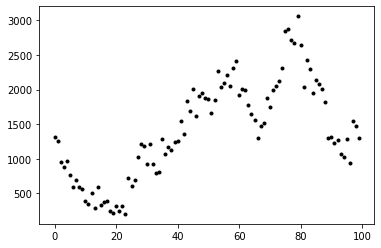

In [11]:
import matplotlib.pyplot as plt
series = data[data.tipo_elem == 'M30']['intensidad'].head(100)
series.plot(style = 'k.')

Analicemos juntos la variable `ocupacion` que _"... define el tiempo de ocupación del punto de medida en el periodo de 15 minutos (%). Un valor negativo implica la ausencia de datos..."_ 

In [12]:
data.ocupacion.describe()

count    1.116615e+07
mean     6.814580e+00
std      1.126364e+01
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      1.000000e+02
Name: ocupacion, dtype: float64

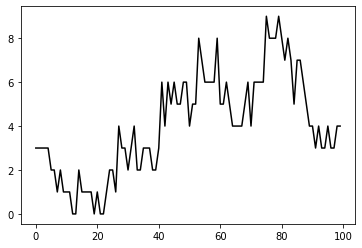

In [13]:
series = data[data.tipo_elem == 'M30']['ocupacion'].head(100)
series.plot(style = 'k-')

Un problema que se hace evidente con las visualizaciones, es la falta de fechas en el eje de las abscisas. Debieramos transformar el juego de datos a una serie de tiempos de verdad.

In [14]:
# Lectura del archivo español como serie de tiempos
ts = pd.read_csv('11-2019.csv', sep = ';', index_col = 1)
ts.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
fecha,,,,,,,,
2019-11-01 00:00:00,1001,M30,1320,3.0,0,50.0,N,5
2019-11-01 00:15:00,1001,M30,1260,3.0,0,54.0,N,5
2019-11-01 00:30:00,1001,M30,948,3.0,0,56.0,N,5
2019-11-01 00:45:00,1001,M30,888,3.0,0,59.0,N,5
2019-11-01 01:00:00,1001,M30,972,3.0,0,59.0,N,5


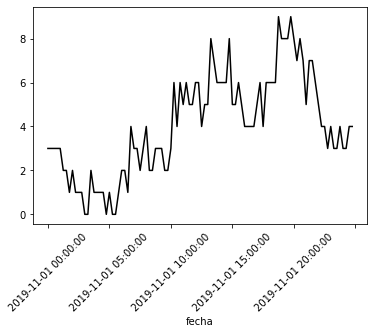

In [15]:
series = ts[ts.tipo_elem == 'M30']['ocupacion'].head(100)
series.plot(style = 'k-')
plt.xticks(rotation=45)
plt.show()

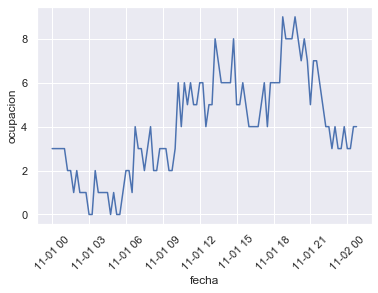

In [16]:
# La misma visualización pero en Seaborn usando la data original
import seaborn as sns
sns.set(style="darkgrid")
sns.lineplot(x = 'fecha', y = 'ocupacion', data = data[data.tipo_elem == 'M30'].head(100))
plt.xticks(rotation=45)
plt.show()

## M30, VELOCIDAD MEDIA E INTENSIDAD DE TRÁFICO
El segundo punto del caso es, para los datos correspondientes a la M30 (vía de circunvalación de la ciudad de Madrid), comparar los valores de velocidad media e intensidad de tráfico entre distintos puntos.

Lo primero que debemos hacer es reducir el juego de datos solamente a aquellos datos que correspondan a la M30. De igual manera eliminemos los juegos de datos `data` y `ts` que ocupan espacio valioso en memoria. 

In [17]:
series = data[data.tipo_elem == 'M30']

del data
del ts
import gc
gc.collect()

2459

Nos hemos quedado con la versión de los datos que no tiene índices de fecha sino fecha como un campo. ¿Podremos agrupar los datos de una variable cualquiera por fecha, como por ejemplo por semana? Ted Petrou nos da un buen ejemplo extraido de https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column

In [18]:
# Solución por Stack Overflow
# https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column
series.groupby(series['fecha'].dt.dayofweek)['intensidad'].agg(['min', 'mean', 'max'])


,min,mean,max
fecha,,,
0,0,1409.533374,8360
1,0,1418.369709,8404
2,0,1433.767815,8437
3,0,1460.738858,8464
4,0,1383.519661,9864
5,0,1148.844224,7792
6,0,1055.724864,7088


Para entender bien el resultado podemos revisar la literatura del método `dateofweek`. 

> Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. This method is available on both Series with datetime values (using the dt accessor) or DatetimeIndex.

La intensidad del tráfico se mantiene bastante estable de lunes a jueves, baja algo el viernes, y realmente un 40% el sábado y domingo. Sin embargo no es la lectura más intuitiva. Tratemos de armar una visualización fuerte que transmita todo esto.

In [19]:
bar = series.groupby(series['fecha'].dt.dayofweek)['intensidad'].agg(['min', 'mean', 'max'])
intensidad = bar['mean'].tolist()

foo = series.groupby(series['fecha'].dt.dayofweek)['vmed'].agg(['min', 'mean', 'max'])
velocidad = foo['mean'].tolist()
velocidad_max = foo['max'].tolist()

data = {'Dia' : ['LUN', 'MAR', 'MIE', 'JUE', 'VIE', 'SAB', 'DOM'], 
        'Intensidad Promedio' : intensidad,
       'Velocidad Promedio' : velocidad,
       'Velocidad Máxima' : velocidad_max}

chart_intensidad = pd.DataFrame(data)
print(chart_intensidad)

   Dia  Intensidad Promedio  Velocidad Promedio  Velocidad Máxima
0  LUN          1409.533374           63.065802             156.0
1  MAR          1418.369709           61.713073             162.0
2  MIE          1433.767815           61.501310             146.0
3  JUE          1460.738858           61.838640             178.0
4  VIE          1383.519661           63.925126             126.0
5  SAB          1148.844224           68.448201             167.0
6  DOM          1055.724864           69.114318             124.0


Cómo tabla de información no está mal, pero podemos mejorarla con las cotas superior e inferior de cada variable. También tratemos de redondear a un solo punto decimal.

In [20]:
bar = series.groupby(series['fecha'].dt.dayofweek)['intensidad'].agg(['std', 'min', 'mean', 'max'])
foo = series.groupby(series['fecha'].dt.dayofweek)['vmed'].agg(['std', 'min', 'mean', 'max'])

intensidad_promedio = round(bar['mean'],1)
intensidad_maxima = round(bar['max'], 1)
intensidad_std = round(bar['std'], 1)

velocidad_promedio = round(foo['mean'],1)
velocidad_maxima = round(foo['max'], 1)
velocidad_std = round(foo['std'], 1)

data = {'Dia' : ['LUN', 'MAR', 'MIE', 'JUE', 'VIE', 'SAB', 'DOM'], 
       'Intensidad Promedio' : intensidad_promedio,
       'Intensidad Máxima' : intensidad_maxima,
       'Intensidad STD' : intensidad_std, 
       'Velocidad Promedio' : velocidad_promedio,
       'Velocidad Máxima' : velocidad_maxima,
       'Velocidad STD' : velocidad_std}

chart_intensidad = pd.DataFrame(data)
# Omitir índice del dataframe
# https://stackoverflow.com/questions/24644656/how-to-print-pandas-dataframe-without-index
print(chart_intensidad.to_string(index=False))

 Dia  Intensidad Promedio  Intensidad Máxima  Intensidad STD  Velocidad Promedio  Velocidad Máxima  Velocidad STD
 LUN               1409.5               8360          1452.3                63.1             156.0           21.8
 MAR               1418.4               8404          1468.1                61.7             162.0           22.5
 MIE               1433.8               8437          1463.5                61.5             146.0           22.4
 JUE               1460.7               8464          1484.4                61.8             178.0           22.3
 VIE               1383.5               9864          1386.7                63.9             126.0           21.2
 SAB               1148.8               7792          1122.0                68.4             167.0           19.0
 DOM               1055.7               7088          1068.0                69.1             124.0           19.2


In [21]:
from IPython.display import display, HTML
display(chart_intensidad)

,Dia,Intensidad Promedio,Intensidad Máxima,Intensidad STD,Velocidad Promedio,Velocidad Máxima,Velocidad STD
fecha,,,,,,,
0,LUN,1409.5,8360,1452.3,63.1,156.0,21.8
1,MAR,1418.4,8404,1468.1,61.7,162.0,22.5
2,MIE,1433.8,8437,1463.5,61.5,146.0,22.4
3,JUE,1460.7,8464,1484.4,61.8,178.0,22.3
4,VIE,1383.5,9864,1386.7,63.9,126.0,21.2
5,SAB,1148.8,7792,1122.0,68.4,167.0,19.0
6,DOM,1055.7,7088,1068.0,69.1,124.0,19.2


## Analizando la Carga de Tráfico
Arriba hemos visto patrones de intensidad y velocidad agrupados por dia, pero no hemos visto el congestionamiento, registrado en la variable `carga`.

In [22]:
carga = series.groupby(series['fecha'].dt.dayofweek)['carga'].agg(['std', 'min', 'mean', 'max'])

carga_minimo = round(carga['min'],1)
carga_promedio = round(carga['mean'],1)
carga_maximo = round(carga['max'], 1)

carga_dat = {
    'Dia' : ['LUN', 'MAR', 'MIE', 'JUE', 'VIE', 'SAB', 'DOM'], 
    'Mínimo' : carga_minimo,
    'Promedio' : carga_promedio,
    'Máximo' : carga_maximo}

carga_chart = pd.DataFrame(carga_dat)
display(carga_chart)

,Dia,Mínimo,Promedio,Máximo
fecha,,,,
0,LUN,0,29.2,100
1,MAR,0,29.4,100
2,MIE,0,29.8,100
3,JUE,0,30.2,100
4,VIE,0,28.7,100
5,SAB,0,24.2,100
6,DOM,0,22.1,100


No está mal, pero esperabamos mucho más. Nos gustaría poder condensar la información por día y por hora, tener un registro de las 24 horas del día, para entonces si obtener una matriz con datos muy interesantes de evaluar. La información está en intervalos de 15 minutos sin embargo, lo que significa que hay 96 puntos de datos por día, no 24. ¿Cuál de los dos podemos usar por ahora que nos permite agrupar de forma funcional y sin definir métodos complejos?

In [23]:
# Agregar una columna al juego de datos que identifique el dia de la semana para filtrar mejor
series['dia'] = series['fecha'].dt.dayofweek
lunes = series[series['dia'] == 0]
carga = lunes.groupby(lunes['fecha'].dt.hour)['carga'].agg(['std', 'min', 'mean', 'max'])
display(carga)

,std,min,mean,max
fecha,,,,
0,8.801378,0,9.058108,95
1,4.658560,0,4.530480,49
2,2.945353,0,2.627027,44
3,2.235266,0,1.988589,27
4,2.751468,0,2.325871,32
5,6.521111,0,5.238582,91
6,23.038805,0,19.974800,100
7,33.836152,0,39.381940,100
8,35.612234,0,45.071797,100


Automaticemos el proceso generando una matriz de 24 columnas, una para cada hora del día, y 7 filas, una para cada dia de la semana. Este gran dataframe es importante para poder visualizar bien el flujo de carga.

In [24]:
import numpy as np
matriz_carga = np.zeros((7,24))

In [25]:
for i in range(0,7):
    datos_temporal = series[series['dia'] == i]
    carga = datos_temporal.groupby(datos_temporal['fecha'].dt.hour)['carga'].agg(['mean'])
    for j in range(0,24):
        matriz_carga[i, j] = round(carga['mean'][j],1)


In [91]:
temp = {
    'HORA' : ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00',
             '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00',
             '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
             '21:00', '22:00', '23:00'],
    'LUNES' : matriz_carga[0,:].tolist(),
    'MARTES' : matriz_carga[1,:].tolist(),
    'MIERCOLES': matriz_carga[2,:].tolist(),
    'JUEVES' : matriz_carga[3,:].tolist(),
    'VIERNES' : matriz_carga[4,:].tolist(),
    'SABADO' : matriz_carga[5,:].tolist(),
    'DOMINGO' : matriz_carga[6,:].tolist()
}

df = pd.DataFrame(temp)
df.set_index('HORA', inplace = True)
display(df)

,LUNES,MARTES,MIERCOLES,JUEVES,VIERNES,SABADO,DOMINGO
HORA,,,,,,,
0:00,9.1,8.0,9.9,10.8,13.0,16.0,17.5
1:00,4.5,3.9,4.7,5.2,7.4,12.3,13.7
2:00,2.6,2.4,3.0,2.9,4.6,8.2,8.9
3:00,2.0,2.1,2.2,2.3,3.5,5.9,6.5
4:00,2.3,2.4,2.5,2.7,3.6,5.0,5.1
5:00,5.2,5.1,5.2,5.2,5.7,5.3,5.0
6:00,20.0,19.8,20.2,20.1,17.9,9.1,8.0
7:00,39.4,39.4,39.5,39.3,33.9,12.8,10.1
8:00,45.1,45.3,45.2,44.9,38.7,17.1,11.1


Para una estructura matricial como la de arriba, donde lo que queremos ver es los patrones de carga de la ruta M30, lo mejor es un mapa de calor, o __heatmap__. Justamente la librería _Seaborn_ tiene modelos muy interesantes para usar.

Text(0.5, 1, 'ANALISIS DE CARGA PROMEDIO DE TRAFICO POR HORA \n EN LA AUTOPISTA M30')

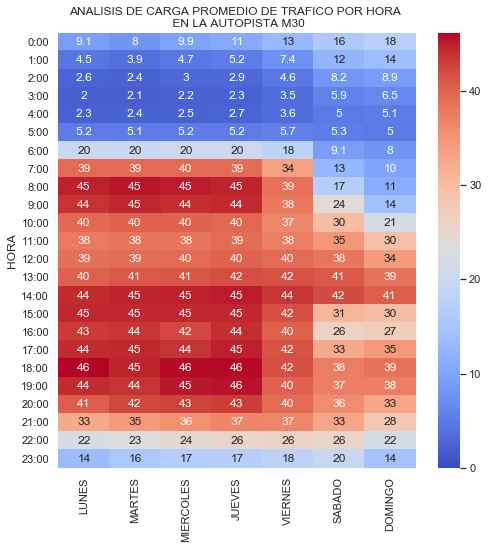

In [92]:
# Code from Stack Overflow to obtain maximum of multiple columns
# https://stackoverflow.com/questions/12169170/find-the-max-of-two-or-more-columns-with-pandas
temp_max_load = df[['LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'DOMINGO']].max(axis=1)
maximum_load = max(temp_max_load)

plt.figure(figsize=(8, 8))
sns.heatmap(df, vmin=0, vmax=maximum_load, cmap="coolwarm", annot = True).set_title('ANALISIS DE CARGA PROMEDIO DE TRAFICO POR HORA \n EN LA AUTOPISTA M30')

Un desafio interesante es transformar la estructura de datos para usarla en un __boxplot__. Después de mucho experiemento, ya que utilizar `stack()` es bastante _hacky_ al momento de asignar nombre a las columnas con valores y se pierde mucho poder de visualización, hacemos el primer intento con la función `melt()`. El tutorial es de _Soner Yıldırım_ y se encuentra en _"Reshaping Pandas DataFrames - Melt, Stack and Pivot functions"_ en el sitio https://towardsdatascience.com/reshaping-pandas-dataframes-9812b3c1270e.

In [94]:
df3 = df.melt()
df3.head()

,variable,value
0,LUNES,9.1
1,LUNES,4.5
2,LUNES,2.6
3,LUNES,2.0
4,LUNES,2.3


Text(0.5, 1.0, 'ANALISIS DE CARGA PROMEDIO DE TRAFICO POR DIA \n EN LA AUTOPISTA M30')

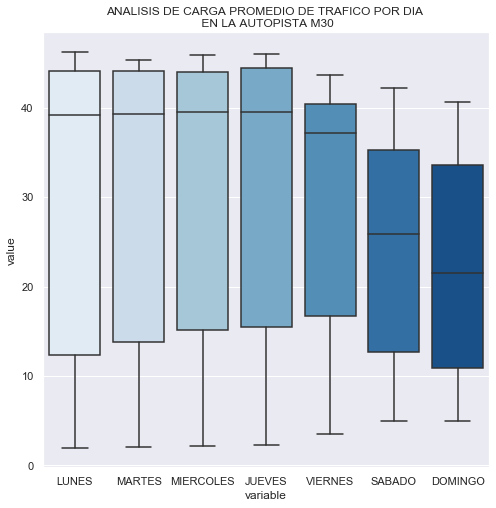

In [100]:
plt.figure(figsize=(8, 8))
sns.boxplot(y='value', x='variable', data=df3, palette="Blues").set_title('ANALISIS DE CARGA PROMEDIO DE TRAFICO POR DIA \n EN LA AUTOPISTA M30')

Lo extraño de como funcionó `melt()` es que se perdió la variable de horas. Sospecho que es el efecto de tener el __dataframe__ indexado con la columna hora. Quizás es mejor crear un nuevo df sin índice para _derretir_.

In [101]:
temp = {
    'HORA' : ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00',
             '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00',
             '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
             '21:00', '22:00', '23:00'],
    'LUNES' : matriz_carga[0,:].tolist(),
    'MARTES' : matriz_carga[1,:].tolist(),
    'MIERCOLES': matriz_carga[2,:].tolist(),
    'JUEVES' : matriz_carga[3,:].tolist(),
    'VIERNES' : matriz_carga[4,:].tolist(),
    'SABADO' : matriz_carga[5,:].tolist(),
    'DOMINGO' : matriz_carga[6,:].tolist()
}

df5 = pd.DataFrame(temp)
display(df5)

,HORA,LUNES,MARTES,MIERCOLES,JUEVES,VIERNES,SABADO,DOMINGO
0,0:00,9.1,8.0,9.9,10.8,13.0,16.0,17.5
1,1:00,4.5,3.9,4.7,5.2,7.4,12.3,13.7
2,2:00,2.6,2.4,3.0,2.9,4.6,8.2,8.9
3,3:00,2.0,2.1,2.2,2.3,3.5,5.9,6.5
4,4:00,2.3,2.4,2.5,2.7,3.6,5.0,5.1
5,5:00,5.2,5.1,5.2,5.2,5.7,5.3,5.0
6,6:00,20.0,19.8,20.2,20.1,17.9,9.1,8.0
7,7:00,39.4,39.4,39.5,39.3,33.9,12.8,10.1
8,8:00,45.1,45.3,45.2,44.9,38.7,17.1,11.1
9,9:00,43.9,44.6,44.3,44.4,38.1,24.1,14.3


In [103]:
df6 = df5.melt(id_vars=['HORA'])
df6.head()

,HORA,variable,value
0,0:00,LUNES,9.1
1,1:00,LUNES,4.5
2,2:00,LUNES,2.6
3,3:00,LUNES,2.0
4,4:00,LUNES,2.3


In [106]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HORA      168 non-null    object 
 1   variable  168 non-null    object 
 2   value     168 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.1+ KB


Text(0.5, 1.0, 'ANALISIS DE CARGA PROMEDIO DE TRAFICO POR HORA \n EN LA AUTOPISTA M30')

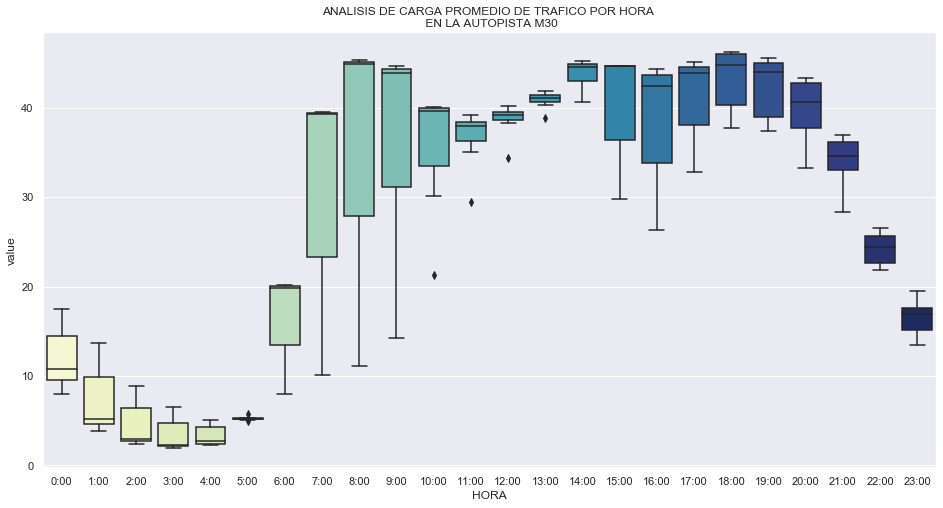

In [112]:
plt.figure(figsize=(16, 8))
sns.boxplot(y='value', x='HORA', data=df6, palette="YlGnBu").set_title('ANALISIS DE CARGA PROMEDIO DE TRAFICO POR HORA \n EN LA AUTOPISTA M30')

¿Sería esta una mejor estructura que la primera tan solo por quitar el índice de __HORA__? Tratemos de replicar el gráfico primero por día y veamos. 

Text(0.5, 1.0, 'ANALISIS DE CARGA PROMEDIO DE TRAFICO POR DIA \n EN LA AUTOPISTA M30')

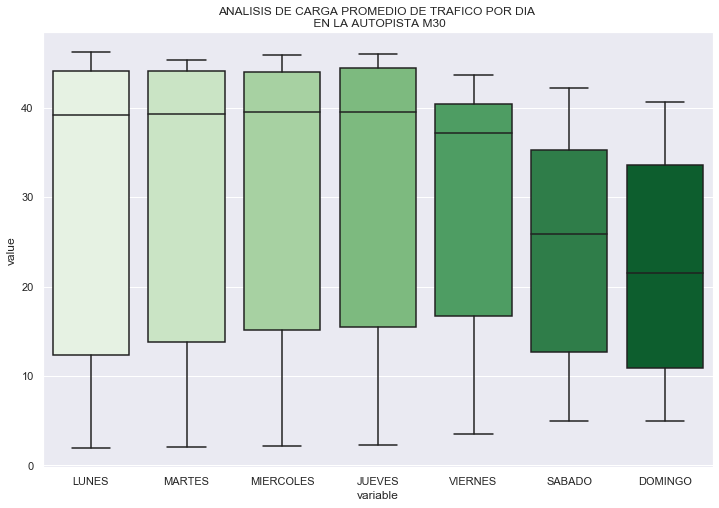

In [113]:
plt.figure(figsize=(12, 8))
sns.boxplot(y='value', x='variable', data=df6, palette="Greens").set_title('ANALISIS DE CARGA PROMEDIO DE TRAFICO POR DIA \n EN LA AUTOPISTA M30')

Vamos a limpiar un poco este __dataframe__ valioso que sacamos usando el método `melt()` con nombres mejores a las variables y columnas. La pregunta es no porque las HORAS no están indexadas, y _Seaborn_ no reconoce el formato. Pero debe haber una forma de hacerlo.

In [116]:
analisis_carga_M30 = df5.melt(id_vars=['HORA'], var_name = 'DIA', value_name = 'CARGA').sort_values(by='HORA').reset_index(drop=True)
analisis_carga_M30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HORA    168 non-null    object 
 1   DIA     168 non-null    object 
 2   CARGA   168 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.1+ KB


La pregunta de oro es: ¿podemos replicar el mapa de calor de horas y días con este formato? La respuesta por ahora es no, ya que no está indexado por __HORA__ y _Seaborn_ pierde el control del plot.